# 代码来源：https://blog.csdn.net/qq_42818403/article/details/122907583

In [100]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

print(sys.executable)

D:\anaconda\python.exe
D:\anaconda\python.exe


In [101]:
#周期性边界条件
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi/2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


In [102]:
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    
    
    f_u1 = (
        u1_t + v1_xx  
        + 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * v1 - 2*v1*(v2 ** 2 - u2 ** 2) - 4*u1*u2*v2
    )
    f_v1 = (
        v1_t - u1_xx  
        - 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * u1 - 2*u1*(v2 ** 2 - u2 ** 2) + 4*v1*v2*u2
    )
    u1_tx = dde.grad.jacobian(u1_t, x, j=0)
    u1_tt = dde.grad.jacobian(u1_t, x, j=1)
    v1_tx = dde.grad.jacobian(v1_t, x, j=0)
    v1_tt = dde.grad.jacobian(v1_t, x, j=1)
    
    u1_xxx = dde.grad.jacobian(u1_xx, x, j=0)
    u1_xxt = dde.grad.jacobian(u1_xx, x, j=1)
    v1_xxx = dde.grad.jacobian(v1_xx, x, j=0)
    v1_xxt = dde.grad.jacobian(v1_xx, x, j=1)
        
    f_u1x = (
        u1_tx + v1_xxx 
        + 2*(2*v1*v1_x + 2*u1*u1_x + 4*v2*v2_x + 4*u2*u2_x)*v1 + 2*(v1**2 + u1**2 + 2*(v2**2 + u2**2))*v1_x 
        - 2*v1_x*(v2**2 - u2**2) - 2*v1*(2*v2*v2_x - 2*u2*u2_x) 
        - 4*u1_x*u2*v2 - 4*u1*u2_x*v2 - 4*u1*u2*v2_x
    )
    f_u1t = (
        u1_tt + v1_xxt
        + 2*(2*v1*v1_t + 2*u1*u1_t + 4*v2*v2_t + 4*u2*u2_t)*v1 + 2*(v1**2 + u1**2 + 2*(v2**2 + u2**2))*v1_t
        - 2*v1_t*(v2**2 - u2**2) - 2*v1*(2*v2*v2_t - 2*u2*u2_t) 
        - 4*u1_t*u2*v2 - 4*u1*u2_t*v2 - 4*u1*u2*v2_t
    )
    f_v1x = (
        v1_tx - u1_xxx
        + 2*(2*v1*v1_x + 2*u1*u1_x + 4*v2*v2_x + 4*u2*u2_x)*u1 + 2*(v1**2 + u1**2 + 2*(v2**2 + u2**2))*u1_x 
        - 2*u1_x*(v2**2 - u2**2) - 2*u1*(2*v2*v2_x - 2*u2*u2_x) 
        + 4*v1_x*v2*u2 + 4*v1*v2_x*u2 + 4*v1*v2*u2_x
    )
    f_v1t = (
        v1_tt - u1_xxt
        + 2*(2*v1*v1_t + 2*u1*u1_t + 4*v2*v2_t + 4*u2*u2_t)*u1 + 2*(v1**2 + u1**2 + 2*(v2**2 + u2**2))*u1_t 
        - 2*u1_t*(v2**2 - u2**2) - 2*u1*(2*v2*v2_t - 2*u2*u2_t) 
        + 4*v1_t*v2*u2 + 4*v1*v2_t*u2 + 4*v1*v2*u2_t
    )
    
        
    f_u2 = (
        u2_t + v2_xx  
        + 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * v2 - 2*v2*(v1 ** 2 - u1 ** 2) - 4*v1*u2*u1
    )
    f_v2 = (
        v2_t - u2_xx  
        - 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * u2 - 2*u2*(v1 ** 2 - u1 ** 2) + 4*v2*v1*u1
    )
    u2_tx = dde.grad.jacobian(u2_t, x, j=0)
    u2_tt = dde.grad.jacobian(u2_t, x, j=1)
    v2_tx = dde.grad.jacobian(v2_t, x, j=0)
    v2_tt = dde.grad.jacobian(v2_t, x, j=1)
    
    u2_xxx = dde.grad.jacobian(u2_xx, x, j=0)
    u2_xxt = dde.grad.jacobian(u2_xx, x, j=1)
    v2_xxx = dde.grad.jacobian(v2_xx, x, j=0)
    v2_xxt = dde.grad.jacobian(v2_xx, x, j=1)
    
    f_u2x = (
        u2_tx + v2_xxx 
        + 2*(2*v2*v2_x + 2*u2*u2_x + 4*v1*v1_x + 4*u1*u1_x)*v2 + 2*(v2**2 + u2**2 + 2*(v1**2 + u1**2))*v2_x 
        - 2*v2_x*(v1**2 - u1**2) - 2*v2*(2*v1*v1_x - 2*u1*u1_x) 
        - 4*u2_x*u1*v1 - 4*u2*u1_x*v1 - 4*u2*u1*v1_x
    )
    f_u2t = (
        u2_tt + v2_xxt
        + 2*(2*v2*v2_t + 2*u2*u2_t + 4*v1*v1_t + 4*u1*u1_t)*v2 + 2*(v2**2 + u2**2 + 2*(v1**2 + u1**2))*v2_t 
        - 2*v2_t*(v1**2 - u1**2) - 2*v2*(2*v1*v1_t - 2*u1*u1_t) 
        - 4*u2_t*u1*v1 - 4*u2*u1_t*v1 - 4*u2*u1*v1_t
    )
    f_v2x = (
        v2_tx - u2_xxx
        + 2*(2*v2*v2_x + 2*u2*u2_x + 4*v1*v1_x + 4*u1*u1_x)*u2 + 2*(v2**2 + u2**2 + 2*(v1**2 + u1**2))*u2_x 
        - 2*u2_x*(v1**2 - u1**2) - 2*u2*(2*v1*v1_x - 2*u1*u1_x) 
        + 4*v2_x*v1*u1 + 4*v2*v1_x*u1 + 4*v2*v1*u1_x
    )
    f_v2t = (
        v2_tt - u2_xxt
        + 2*(2*v2*v2_t + 2*u2*u2_t + 4*v1*v1_t + 4*u1*u1_t)*u2 + 2*(v2**2 + u2**2 + 2*(v1**2 + u1**2))*u2_t 
        - 2*u2_t*(v1**2 - u1**2) - 2*u2*(2*v1*v1_t - 2*u1*u1_t) 
        + 4*v2_t*v1*u1 + 4*v2*v1_t*u1 + 4*v2*v1*u1_t
    )
    
    
    return [
        f_u1, f_v1, f_u2, f_v2,
        #f_u1x, f_u1t,
        #f_v1x, f_v1t,
        #f_u2x, f_u2t,
        #f_v2x, f_v2t
    ]
 

In [103]:
# 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#(e^c=...)
# 初始条件
def init_cond_u1(x):
    #"2 sech(x)"
    return (1/2) * np.cos(x[:, 0:1]-(-0.587/2)) * np.exp(0.587/2) / np.cosh(1.5*x[:, 0:1]+(-0.587/2) )
def init_cond_u2(x):
    #"2 tanh(x)"
    return np.cos(x[:, 0:1]-(-0.587/2)) * np.exp(0.587/2) / np.cosh(1.5*x[:, 0:1]+(-0.587/2))

def init_cond_v1(x):
    return (1/2) * np.sin(-x[:, 0:1]-(-0.587/2)) * np.exp(0.587/2) / np.cosh(1.5*x[:, 0:1]+(-0.587/2))

def init_cond_v2(x):
    return np.sin(x[:, 0:1]-(-0.587/2)) * np.exp(0.587/2) / np.cosh(1.5*x[:, 0:1]+(-0.587/2))

ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)


In [104]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 5 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)


Adam 优化

In [105]:

# 强烈建议使用 GPU 加速系统.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=5000, display_every=1000)


Compiling model...
Building feed-forward neural network...
'build' took 0.106612 s

'compile' took 30.034483 s

Initializing variables...
Training model...

0         [7.81e-05, 4.76e-05, 2.22e-05, 1.64e-05, 5.72e-03, 1.05e-04, 5.72e-03, 1.07e-04, 9.57e-03, 2.79e-04, 7.02e-04, 3.40e-06, 4.22e-02, 1.60e-02, 1.66e-01, 8.10e-02]    [7.81e-05, 4.76e-05, 2.22e-05, 1.64e-05, 5.72e-03, 1.05e-04, 5.72e-03, 1.07e-04, 9.57e-03, 2.79e-04, 7.02e-04, 3.40e-06, 4.22e-02, 1.60e-02, 1.66e-01, 8.10e-02]    []  
1000      [8.02e-04, 6.03e-04, 5.48e-04, 6.59e-04, 3.21e-05, 1.64e-05, 8.17e-06, 6.96e-06, 7.06e-06, 9.45e-06, 2.18e-05, 1.47e-05, 4.85e-04, 5.39e-04, 3.96e-04, 4.59e-04]    [8.02e-04, 6.03e-04, 5.48e-04, 6.59e-04, 3.21e-05, 1.64e-05, 8.17e-06, 6.96e-06, 7.06e-06, 9.45e-06, 2.18e-05, 1.47e-05, 4.85e-04, 5.39e-04, 3.96e-04, 4.59e-04]    []  
2000      [4.37e-04, 3.46e-04, 3.56e-04, 2.96e-04, 5.43e-05, 1.22e-05, 4.84e-06, 2.21e-05, 1.30e-05, 6.91e-06, 1.10e-05, 1.78e-05, 3.15e-04, 3.66e-04, 1.92e-

(<deepxde.model.LossHistory at 0x2223507cb50>,
 <deepxde.model.TrainState at 0x2221575b550>)

L-BFGS 优化

Compiling model...
'compile' took 23.247982 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
5000      [2.61e-04, 3.17e-04, 1.91e-04, 1.76e-04, 4.90e-05, 8.24e-06, 7.19e-06, 1.41e-05, 2.61e-05, 4.90e-06, 1.88e-05, 3.43e-05, 1.77e-04, 1.87e-04, 9.36e-05, 6.21e-05]    [2.61e-04, 3.17e-04, 1.91e-04, 1.76e-04, 4.90e-05, 8.24e-06, 7.19e-06, 1.41e-05, 2.61e-05, 4.90e-06, 1.88e-05, 3.43e-05, 1.77e-04, 1.87e-04, 9.36e-05, 6.21e-05]    []  
6000      [1.16e-04, 1.03e-04, 4.81e-05, 5.92e-05, 2.88e-06, 8.27e-06, 2.83e-06, 3.67e-06, 1.29e-06, 3.55e-06, 2.42e-07, 1.84e-06, 1.12e-04, 1.09e-04, 4.95e-05, 4.15e-05]                                                                       

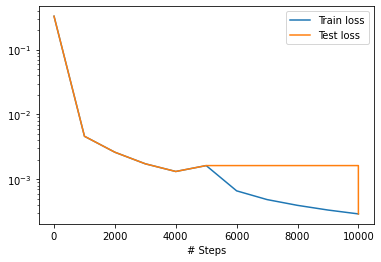

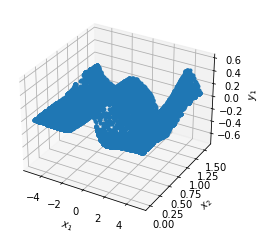

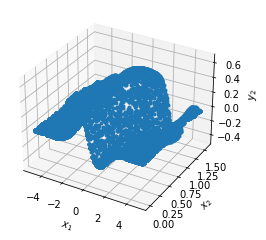

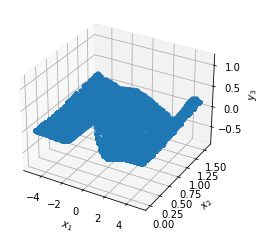

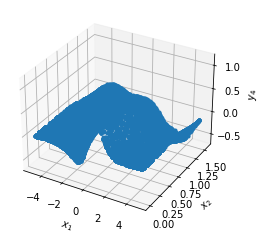

In [106]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=5000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

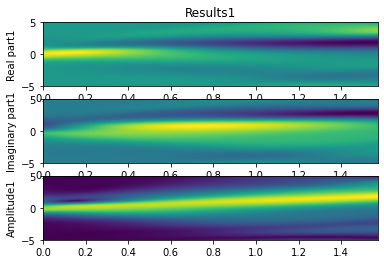

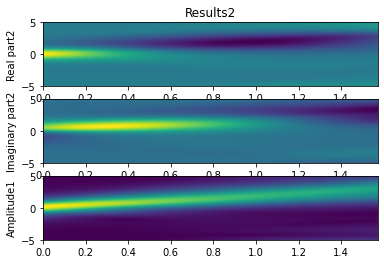

In [107]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()


[   5752    5751    5759 ... 9778962 8782747 7849428]


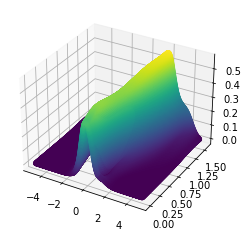

In [108]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:])



[    191449     159503     131469 ... 1991538048 1898364160 1808688000]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


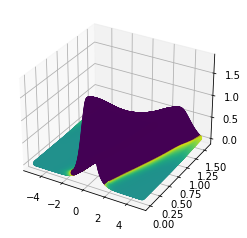

In [109]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:]/10)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [ ]:
X = geomtime.random_points(100000)
err = 1
while err > 0.005:
    f = model.predict(X, operator=pde)
    print(np.array(f).shape)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))
    err_eq=np.sum(err_eq,axis=0)
    print(err_eq.shape)
    x_id = np.argmax(err_eq)
    print(x_id)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train(callbacks=[early_stopping])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata(callbacks=[early_stopping])
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

(4, 100000, 1)
Mean residual: 4.385e-03
(100000, 1)
47977
Adding new point: [0.15961266 0.0008777 ] 

Compiling model...
'compile' took 28.190205 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
10001     [4.32e-05, 4.56e-05, 2.48e-05, 2.73e-05, 1.92e-06, 1.42e-06, 8.73e-07, 2.55e-06, 6.83e-07, 7.79e-07, 9.88e-07, 1.28e-06, 4.17e-05, 5.22e-05, 2.31e-05, 2.40e-05]    [4.30e-05, 4.55e-05, 2.46e-05, 2.73e-05, 1.92e-06, 1.42e-06, 8.73e-07, 2.55e-06, 6.83e-07, 7.79e-07, 9.89e-07, 1.28e-06, 4.17e-05, 5.22e-05, 2.31e-05, 2.40e-05]    []  
11000     [1.03e-04, 8.42e-05, 5.38e-05, 1.39e-04, 2.13e-05, 5.93e-06, 5.81e-06, 9.31e-06, 2.97e-06, 2.57e-06, 8.82e-06, 1.71e-06, 6.16e-05